In [ ]:
%pip install tensorflow

In [ ]:
# Numpy y pandas para procesamiento de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Configuración de gráficos
%matplotlib inline

# Progreso en loops
from tqdm import tqdm

# Scikit-learn: preprocesamiento, evaluación y división de datos
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split

# TensorFlow y Keras: modelos y capas
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, GRU, SimpleRNN,
    Dense, Activation, Dropout,
    Embedding, BatchNormalization,
    GlobalMaxPooling1D, Conv1D, MaxPooling1D,
    Flatten, Bidirectional, SpatialDropout1D
)
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
train = pd.read_csv('/content/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/content/validation.csv')
test = pd.read_csv('/content/test.csv')

# Exp

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.dropna()
test.dropna()

textID                                               text sentiment
0     f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1     96d74cb729   Shanghai is also really exciting (precisely -...  positive
2     eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3     01082688c6                                        happy bday!  positive
4     33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive
...          ...                                                ...       ...
3529  e5f0e6ef4b  its at 3 am, im very tired but i can`t sleep  ...  negative
3530  416863ce47  All alone in this old house again.  Thanks for...  positive
3531  6332da480c   I know what you mean. My little dog is sinkin...  negative
3532  df1baec676  _sutra what is your next youtube video gonna b...  positive
3533  469e15c5a8   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[3534 rows x 3 columns]

In [ ]:
train.shape

(27481, 4)

In [ ]:
train.head(5)

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [ ]:
train['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [ ]:
trainNeutral = train.loc[train['sentiment'] == 'neutral'].iloc[:7700,:]
trainPositive = train.loc[train['sentiment'] == 'positive'].iloc[:7700,:]
trainNegative = train.loc[train['sentiment'] == 'negative'].iloc[:7700,:]

# Combinar datos tóxicos y no tóxicos
trainData = pd.concat([trainNeutral, trainPositive,trainNegative], axis=0).reset_index(drop=True)
trainData.shape

(23100, 4)

In [ ]:
trainData['text'].apply(lambda x:len(str(x).split())).max()

32

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Codificar etiquetas
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(trainData['sentiment'])
integer_encoded_test = label_encoder.fit_transform(test['sentiment'])

# One-hot encoding de las etiquetas
onehot_encoder = OneHotEncoder(sparse_output=False)
labels_encoded = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))
labels_encoded_test = onehot_encoder.fit_transform(integer_encoded_test.reshape(-1, 1))

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(
    trainData.text.values,
    labels_encoded,
    random_state=42,
    test_size=0.2
)
print(f"Tamaño del conjunto de entrenamiento: {len(xtrain)} muestras")
print(f"Tamaño del conjunto de validación: {len(xvalid)} muestras")

Tamaño del conjunto de entrenamiento: 18480 muestras
Tamaño del conjunto de validación: 4620 muestras


# Exp LSTM

In [ ]:
xtrain = xtrain.astype(str)
xvalid = xvalid.astype(str)
test['text'] = test['text'].astype(str)

token = text.Tokenizer(num_words=None)
max_len = 40

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(test['text'])

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index
print(f"Tamaño del vocabulario: {len(word_index)}")

Tamaño del vocabulario: 23783


In [ ]:
def model_RNN(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                        300,
                        input_length=max_len))
        model.add(SimpleRNN(100))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

In [ ]:
parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 5,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_simpleRNN = model_RNN(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4435 - loss: 1.0237 - val_accuracy: 0.6569 - val_loss: 0.7704
Epoch 2/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8279 - loss: 0.4696 - val_accuracy: 0.6223 - val_loss: 0.8920
Epoch 3/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9577 - loss: 0.1369 - val_accuracy: 0.6255 - val_loss: 1.0941
Epoch 4/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9848 - loss: 0.0532 - val_accuracy: 0.6210 - val_loss: 1.3827
Epoch 5/5
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9924 - loss: 0.0257 - val_accuracy: 0.6284 - val_loss: 1.6145
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5910 - loss: 1.7535
[1.7248369455337524, 0.5979060530662537] Results test


In [ ]:
def reviewToxic(model, text, tokenizer, max_len):
    """
    Realiza una predicción sobre si un texto es tóxico o no.

    Parámetros:
    - model: Modelo entrenado de clasificación de toxicidad.
    - text: Texto de entrada que se desea evaluar.
    - tokenizer: Instancia de `Tokenizer` utilizada para entrenar el modelo.
    - max_len: Longitud máxima de las secuencias de entrada utilizada en el modelo.

    Retorno:
    - str: "Tóxico" si el modelo predice que el texto es tóxico, "No tóxico" en caso contrario.
    """
    # Preprocesamiento del texto
    text_sequence = tokenizer.texts_to_sequences([text])  # Convierte el texto a secuencia
    text_padded = sequence.pad_sequences(text_sequence, maxlen=max_len)  # Padding

    # Predicción
    prediction = model.predict(text_padded)  # El modelo devuelve un array con las probabilidades

    # Asignamos la clase con la mayor probabilidad
    predicted_class = prediction.argmax(axis=-1)  # Índice de la clase con la mayor probabilidad

    # Mapear el índice a las clases correspondientes
    class_labels = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

    return class_labels[predicted_class[0]]  # Devolver la clase como string

In [ ]:
# Supongamos que ya tienes el modelo, el tokenizer y el max_len definidos
texto = "This product is excellent,Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140. my first product to buy"

prediccion = reviewToxic(toxic_LSTM, texto, token, max_len)
print(prediccion)  # Devolverá "Positivo", "Negativo" o "Neutro"


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
Positivo


In [ ]:
!wget http://www-nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip

--2024-11-27 15:23:24--  http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Resolving www-nlp.stanford.edu (www-nlp.stanford.edu)... 171.64.67.140
Connecting to www-nlp.stanford.edu (www-nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2024-11-27 15:23:25--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2024-11-27 15:23:25--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTT

In [ ]:
glove_dir = '/content/glove.840B.300d.txt'

In [ ]:
embeddings_index = {}
f = open(glove_dir,'r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [05:27, 6695.24it/s]


Found 2196016 word vectors.


In [ ]:
# Crear una matriz embedding para las palabras del dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 23783/23783 [00:00<00:00, 125540.54it/s]


In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):
    with strategy.scope():
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
        model.add(LSTM(64, return_sequences=True))
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
        model.add(LSTM(100))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

In [ ]:
parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5351 - loss: 0.9253 - val_accuracy: 0.7219 - val_loss: 0.6738
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7358 - loss: 0.6466 - val_accuracy: 0.7472 - val_loss: 0.6182
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7626 - loss: 0.5759 - val_accuracy: 0.7310 - val_loss: 0.6476
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7911 - loss: 0.5266 - val_accuracy: 0.7439 - val_loss: 0.6304
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8145 - loss: 0.4679 - val_accuracy: 0.7387 - val_loss: 0.6673
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8358 - loss: 0.4133 - val_accuracy: 0.7333 - val_loss: 0.6724
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8605 - loss: 0.3596 - val_accuracy: 0.7247 - val_loss: 0.7145
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8797 - loss: 0.3162 - val_accu

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
        model.add(LSTM(32))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5614 - loss: 0.9129 - val_accuracy: 0.7017 - val_loss: 0.6978
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7211 - loss: 0.6610 - val_accuracy: 0.7301 - val_loss: 0.6461
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7582 - loss: 0.5824 - val_accuracy: 0.7381 - val_loss: 0.6303
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7755 - loss: 0.5464 - val_accuracy: 0.7305 - val_loss: 0.6405
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8004 - loss: 0.4890 - val_accuracy: 0.7409 - val_loss: 0.6371
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8245 - loss: 0.4509 - val_accuracy: 0.7409 - val_loss: 0.6492
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8430 - loss: 0.4016 - val_accuracy: 0.7245 - val_loss: 0.7156
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8678 - loss: 0.3504 - val_accur

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
        model.add(LSTM(64))
        model.add(Dropout(params['dropout']))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.2,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5614 - loss: 0.9151 - val_accuracy: 0.7108 - val_loss: 0.6963
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7259 - loss: 0.6485 - val_accuracy: 0.7366 - val_loss: 0.6371
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7606 - loss: 0.5879 - val_accuracy: 0.7387 - val_loss: 0.6279
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7781 - loss: 0.5439 - val_accuracy: 0.7368 - val_loss: 0.6284
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8026 - loss: 0.4871 - val_accuracy: 0.7416 - val_loss: 0.6515
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8283 - loss: 0.4462 - val_accuracy: 0.7452 - val_loss: 0.6642
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8408 - loss: 0.4086 - val_accuracy: 0.7273 - val_loss: 0.7036
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8686 - loss: 0.3486 - val_accu

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(64))
        model.add(Dropout(params['dropout']))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.5,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)             │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5663 - loss: 0.9156 - val_accuracy: 0.7121 - val_loss: 0.6941
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7183 - loss: 0.6710 - val_accuracy: 0.7320 - val_loss: 0.6360
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7517 - loss: 0.6025 - val_accuracy: 0.7429 - val_loss: 0.6219
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7590 - loss: 0.5813 - val_accuracy: 0.7526 - val_loss: 0.6066
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7780 - loss: 0.5450 - val_accuracy: 0.7569 - val_loss: 0.6057
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7959 - loss: 0.5122 - val_accuracy: 0.7517 - val_loss: 0.6275
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8064 - loss: 0.4845 - val_accuracy: 0.7580 - val_loss: 0.6229
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8241 - loss: 0.4415 - val_accu

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(LSTM(12, return_sequences=True))
        model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(64))
        model.add(Dropout(params['dropout']))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.5,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5044 - loss: 0.9690 - val_accuracy: 0.6872 - val_loss: 0.7667
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6880 - loss: 0.7334 - val_accuracy: 0.7268 - val_loss: 0.6679
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7246 - loss: 0.6570 - val_accuracy: 0.7171 - val_loss: 0.6732
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7439 - loss: 0.6213 - val_accuracy: 0.7374 - val_loss: 0.6245
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7564 - loss: 0.5930 - val_accuracy: 0.7452 - val_loss: 0.6162
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7663 - loss: 0.5732 - val_accuracy: 0.7526 - val_loss: 0.6008
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7809 - loss: 0.5452 - val_accuracy: 0.7519 - val_loss: 0.6036
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7829 - loss: 0.5378 - val_a

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(LSTM(12, return_sequences=True))
        model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(64))
        model.add(Dense(16, activation= params['activation']))
        model.add(Dropout(params['dropout']))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.5,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)             │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.4112 - loss: 1.0690 - val_accuracy: 0.6463 - val_loss: 0.9217
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6106 - loss: 0.9137 - val_accuracy: 0.7141 - val_loss: 0.8070
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6666 - loss: 0.8294 - val_accuracy: 0.7290 - val_loss: 0.7480
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6983 - loss: 0.7899 - val_accuracy: 0.7429 - val_loss: 0.7094
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7087 - loss: 0.7540 - val_accuracy: 0.7463 - val_loss: 0.6886
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7232 - loss: 0.7278 - val_accuracy: 0.7524 - val_loss: 0.6596
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7351 - loss: 0.7021 - val_accuracy: 0.7589 - val_loss: 0.6463
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7587 - loss: 0.6659 - val_accu

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(LSTM(12, return_sequences=True))
        model.add(LSTM(32, return_sequences=True))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(100))
        model.add(Dropout(params['dropout']))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.5,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.4841 - loss: 0.9965 - val_accuracy: 0.6424 - val_loss: 0.7821
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6820 - loss: 0.7323 - val_accuracy: 0.7143 - val_loss: 0.6840
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7304 - loss: 0.6507 - val_accuracy: 0.7381 - val_loss: 0.6417
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7473 - loss: 0.6076 - val_accuracy: 0.7351 - val_loss: 0.6316
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7624 - loss: 0.5830 - val_accuracy: 0.7522 - val_loss: 0.6112
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7632 - loss: 0.5799 - val_accuracy: 0.7567 - val_loss: 0.6005
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7774 - loss: 0.5505 - val_accuracy: 0.7569 - val_loss: 0.6071
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7790 - loss: 0.5451 - va

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(LSTM(12, return_sequences=True))
        model.add(LSTM(32, return_sequences=True))
        model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
        model.add(LSTM(64, return_sequences=True))
        model.add(LSTM(100))
        model.add(Dropout(params['dropout']))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.5,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.4726 - loss: 1.0005 - val_accuracy: 0.6965 - val_loss: 0.7311
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6992 - loss: 0.7139 - val_accuracy: 0.7273 - val_loss: 0.6610
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7409 - loss: 0.6323 - val_accuracy: 0.7387 - val_loss: 0.6228
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7537 - loss: 0.6035 - val_accuracy: 0.7364 - val_loss: 0.6309
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7668 - loss: 0.5781 - val_accuracy: 0.7506 - val_loss: 0.5993
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7693 - loss: 0.5639 - val_accuracy: 0.7457 - val_loss: 0.6042
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7848 - loss: 0.5393 - val_accuracy: 0.7511 - val_loss: 0.6073
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7913 - loss: 0.5269 - val_ac

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
        model.add(LSTM(100))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5724 - loss: 0.8969 - val_accuracy: 0.7156 - val_loss: 0.6805
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7369 - loss: 0.6337 - val_accuracy: 0.7307 - val_loss: 0.6431
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7616 - loss: 0.5768 - val_accuracy: 0.7366 - val_loss: 0.6227
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7891 - loss: 0.5208 - val_accuracy: 0.7444 - val_loss: 0.6336
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8085 - loss: 0.4702 - val_accuracy: 0.7370 - val_loss: 0.6766
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8430 - loss: 0.4088 - val_accuracy: 0.7130 - val_loss: 0.7176
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8588 - loss: 0.3555 - val_accuracy: 0.7320 - val_loss: 0.7239
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8880 - loss: 0.2995 - val_accuracy: 

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
        model.add(LSTM(100))
        model.add(Dropout(params['dropout']))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.2,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5517 - loss: 0.9182 - val_accuracy: 0.7132 - val_loss: 0.7071
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7221 - loss: 0.6598 - val_accuracy: 0.7260 - val_loss: 0.6437
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7565 - loss: 0.5832 - val_accuracy: 0.7327 - val_loss: 0.6246
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7860 - loss: 0.5314 - val_accuracy: 0.7357 - val_loss: 0.6539
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8064 - loss: 0.4791 - val_accuracy: 0.7392 - val_loss: 0.6878
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8262 - loss: 0.4359 - val_accuracy: 0.7329 - val_loss: 0.6745
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8545 - loss: 0.3737 - val_accuracy: 0.7310 - val_loss: 0.7220
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8772 - loss: 0.3198 - val_accu

In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):
    with strategy.scope():
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
        model.add(LSTM(64, return_sequences=True))
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
        model.add(LSTM(100))
        model.add(Dense(3, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 15,
              'dropout': 0.2,
              'optimizer': 'Adam',
              'loss': 'categorical_crossentropy',
              'activation':'softmax'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad,labels_encoded_test, parameters)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ ?                           │       7,135,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,135,200 (27.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,135,200 (27.22 MB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5597 - loss: 0.9159 - val_accuracy: 0.7177 - val_loss: 0.6715
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7341 - loss: 0.6381 - val_accuracy: 0.7398 - val_loss: 0.6184
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7679 - loss: 0.5649 - val_accuracy: 0.7238 - val_loss: 0.6450
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7957 - loss: 0.5128 - val_accuracy: 0.7184 - val_loss: 0.6804
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8175 - loss: 0.4637 - val_accuracy: 0.7387 - val_loss: 0.6575
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8464 - loss: 0.4033 - val_accuracy: 0.7281 - val_loss: 0.7135
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8642 - loss: 0.3587 - val_accuracy: 0.7212 - val_loss: 0.7499
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8818 - loss: 0.3142 - val_accu

# Exp Bert

In [ ]:
%pip install --upgrade tensorflow tensorflow-text

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
xtrain = xtrain.astype(str)
xvalid = xvalid.astype(str)
test['text'] = test['text'].astype(str)
# Tokeniza los datos de entrenamiento
train_encodings = tokenizer(
    xtrain.tolist(),  # Convierte xtrain a lista si es necesario
    padding=True,  # Añade padding para igualar la longitud de las secuencias
    truncation=True,  # Trunca textos más largos que el límite del modelo (por defecto 512 tokens)
    max_length=128,  # Ajusta según tus necesidades (recomendado: 128 o 256)
    return_tensors="pt"  # Devuelve tensores listos para PyTorch
)

# Lo mismo para los datos de prueba o validación
test_encodings = tokenizer(
    xvalid.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [ ]:
test_encodings_data = tokenizer(
    test['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [ ]:
import torch

# Crea tensores para etiquetas
train_labels = torch.tensor(ytrain)  # Asegúrate de que ytrain sea una lista/array numérica
test_labels = torch.tensor(yvalid)

# Crea Dataset personalizado
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# DataLoader con lotes
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Ajusta el batch_size según tu GPU/CPU
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
test_labels_data = torch.tensor(labels_encoded_test)
test_dataset_data = TensorDataset(test_encodings_data['input_ids'], test_encodings_data['attention_mask'], test_labels_data)
test_loader_data = DataLoader(test_dataset_data, batch_size=64)

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)  # Ajusta el learning rate según tu caso


In [ ]:
import torch

def evaluate(model, test_loader, device):
    model.eval()  # Establece el modelo en modo de evaluación
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Realiza la inferencia
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)  # Predicciones de clase

            # Si las etiquetas son one-hot, conviértelas a índices de clase
            if labels.dim() > 1:  # Esto indica que las etiquetas están en formato one-hot
                labels = torch.argmax(labels, dim=-1)

            # Compara las predicciones con las etiquetas reales
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy



In [ ]:
from transformers import get_scheduler
from torch.nn import CrossEntropyLoss
from torch.cuda import is_available

device = "cuda" if is_available() else "cpu"
model.to(device)

epochs = 5

# Configura un scheduler para ajustar el learning rate
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


loss_fn = CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    # Evaluar precisión después de cada época
    accuracy = evaluate(model, test_loader, device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy:.4f}")


Epoch 1/5, Loss: 0.33585928944456905, Accuracy: 0.7983
Epoch 2/5, Loss: 0.3164842515187855, Accuracy: 0.7989
Epoch 3/5, Loss: 0.17625664348532963, Accuracy: 0.7929
Epoch 4/5, Loss: 0.029958103521494195, Accuracy: 0.7900
Epoch 5/5, Loss: 0.0811034550602522, Accuracy: 0.7916


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader_data:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Realiza la inferencia
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Si las etiquetas están en formato one-hot, conviértelas a índices de clase
        if labels.dim() > 1:  # Si las etiquetas tienen más de una dimensión (probable one-hot)
            labels = torch.argmax(labels, dim=1)

        # Comparar predicciones con etiquetas
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Calcular y mostrar precisión
print(f"Accuracy: {correct / total:.2f}")



Accuracy: 0.78


# Exp Dataset de toxico

In [ ]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [ ]:
train.head(5)

id                                       comment_text  toxic
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0

In [ ]:
train['toxic'].value_counts()

toxic
0    202165
1     21384
Name: count, dtype: int64

In [ ]:
trainToxic = train.loc[train['toxic'] == 1].dropna()

In [ ]:
trainToxic.head(5)

id                                       comment_text  toxic
6   0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1
12  0005c987bdfc9d4b  Hey... what is it..\n@ | talk .\nWhat is it......      1
16  0007e25b2121310b  Bye! \n\nDon't look, come or think of comming ...      1
42  001810bf8c45bf5f  You are gay or antisemmitian? \n\nArchangel WH...      1
43  00190820581d90ce           FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!      1

In [ ]:
trainNoToxic = train.loc[train['toxic'] == 0].dropna()

In [ ]:
trainNoToxic.head(5)

id                                       comment_text  toxic
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0

In [ ]:
print(trainToxic.shape)
print(trainNoToxic.shape)

(21384, 3)
(202165, 3)


In [ ]:
# Seleccionar 6000 datos no tóxicos
trainToxic = train.loc[train['toxic'] == 0].iloc[:20000,:].dropna()
# Seleccionar 6000 datos tóxicos
trainNoToxic = train.loc[train['toxic'] == 1].iloc[:20000,:].dropna()

# Combinar datos tóxicos y no tóxicos
trainData = pd.concat([trainToxic, trainNoToxic], axis=0).reset_index(drop=True)
trainData.shape

(40000, 3)

In [ ]:
trainData['comment_text'].apply(lambda x:len(str(x).split())).max()

2321

**Data Preparation**

In [ ]:
# División inicial: 80% para entrenamiento/validación y 20% para prueba
x_temp, xtest, y_temp, ytest = train_test_split(
    trainData.comment_text.values,
    trainData.toxic.values,
    stratify=trainData.toxic.values,
    random_state=42,
    test_size=0.2,  # 20% para prueba
    shuffle=True
)

# División secundaria: 75% para entrenamiento y 25% para validación del 80% restante
xtrain, xvalid, ytrain, yvalid = train_test_split(
    x_temp,
    y_temp,
    stratify=y_temp,
    random_state=42,
    test_size=0.25  # 25% de 80% equivale a 20% de los datos originales
)

print(f"Tamaño del conjunto de entrenamiento: {len(xtrain)} muestras")
print(f"Tamaño del conjunto de validación: {len(xvalid)} muestras")
print(f"Tamaño del conjunto de prueba: {len(xtest)} muestras")

Tamaño del conjunto de entrenamiento: 24000 muestras
Tamaño del conjunto de validación: 8000 muestras
Tamaño del conjunto de prueba: 8000 muestras


In [ ]:
token = text.Tokenizer(num_words=None)
max_len = 2400

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(xtest)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index
print(f"Tamaño del vocabulario: {len(word_index)}")

Tamaño del vocabulario: 70058


**Model Simple RNN**

In [ ]:
def model_RNN(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                        300,
                        input_length=max_len))
        model.add(SimpleRNN(100))
        model.add(Dense(1, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

In [ ]:
parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 5,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

toxic_simpleRNN = model_RNN(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad, ytest, parameters)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 108s 280ms/step - accuracy: 0.7773 - loss: 0.4605 - val_accuracy: 0.9013 - val_loss: 0.2745
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 140s 278ms/step - accuracy: 0.9474 - loss: 0.1517 - val_accuracy: 0.8783 - val_loss: 0.3102
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 151s 303ms/step - accuracy: 0.9830 - loss: 0.0551 - val_accuracy: 0.8726 - val_loss: 0.3882
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 133s 279ms/step - accuracy: 0.9926 - loss: 0.0261 - val_accuracy: 0.8794 - val_loss: 0.4528
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 151s 302ms/step - accuracy: 0.9919 - loss: 0.0264 - val_accuracy: 0.8650 - val_loss: 0.5045
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.8598 - loss: 0.5277
[0.554183304309845, 0.856374979019165] Results test


In [ ]:
def reviewToxic(model, text, tokenizer, max_len):
    """
    Realiza una predicción sobre si un texto es tóxico o no.

    Parámetros:
    - model: Modelo entrenado de clasificación de toxicidad.
    - text: Texto de entrada que se desea evaluar.
    - tokenizer: Instancia de `Tokenizer` utilizada para entrenar el modelo.
    - max_len: Longitud máxima de las secuencias de entrada utilizada en el modelo.

    Retorno:
    - str: "Tóxico" si el modelo predice que el texto es tóxico, "No tóxico" en caso contrario.
    """
    # Preprocesamiento del texto
    text_sequence = tokenizer.texts_to_sequences([text])  # Convierte el texto a secuencia
    text_padded = sequence.pad_sequences(text_sequence, maxlen=max_len)  # Padding

    # Predicción
    prediction = model.predict(text_padded)

    # Decisión basada en la predicción
    if prediction[0] > 0.5:  # Umbral de clasificación (ajustable si es necesario)
        return "Tóxico"
    else:
        return "No tóxico"


In [ ]:
# Texto de ejemplo
texto = "This is a terrible comment!"

# Llamada a la función
resultado = reviewToxic(toxic_simpleRNN, texto, token, max_len)

print(f"El texto es: {resultado}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
El texto es: Tóxico


In [ ]:
# Texto de ejemplo
texto = "The product met my expectations. Shipping was fast, and the packaging was great."

# Llamada a la función
resultado = reviewToxic(toxic_simpleRNN, texto, token, max_len)

print(f"El texto es: {resultado}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
El texto es: No tóxico


In [ ]:
token

**Model LSTM**

In [ ]:
!wget http://www-nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip



--2024-11-26 17:02:52--  http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Resolving www-nlp.stanford.edu (www-nlp.stanford.edu)... 171.64.67.140
Connecting to www-nlp.stanford.edu (www-nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2024-11-26 17:02:52--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2024-11-26 17:02:52--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTT

In [ ]:
glove_dir = '/content/glove.840B.300d.txt'

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open(glove_dir,'r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:58, 9217.26it/s]

Found 2196016 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 70058/70058 [00:00<00:00, 236898.43it/s]


In [ ]:
def model_LSTM(x_train, y_train, x_val, y_val,x_test, y_test, params):

    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(LSTM(100))
        model.add(Dense(1, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

In [ ]:
parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 5,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

toxic_LSTM = model_LSTM(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad, ytest, parameters)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      21,017,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,017,700 (80.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,017,700 (80.18 MB)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 141ms/step - accuracy: 0.8481 - loss: 0.3526 - val_accuracy: 0.9162 - val_loss: 0.2075
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 131ms/step - accuracy: 0.9139 - loss: 0.2049 - val_accuracy: 0.9331 - val_loss: 0.1750
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 143ms/step - accuracy: 0.9331 - loss: 0.1735 - val_accuracy: 0.9341 - val_loss: 0.1732
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 78s 131ms/step - accuracy: 0.9359 - loss: 0.1672 - val_accuracy: 0.9258 - val_loss: 0.1843
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 143ms/step - accuracy: 0.9426 - loss: 0.1436 - val_accuracy: 0.9331 - val_loss: 0.1655
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9393 - loss: 0.1600
[0.16798733174800873, 0.9362499713897705] Results test


In [ ]:
def model_LSTM2(x_train, y_train, x_val, y_val,x_test, y_test, params):
    with strategy.scope():
        # A simpleRNN without any pretrained embeddings and one dense layer
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
        model.add(LSTM(64, return_sequences=True))
        model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
        model.add(LSTM(64))
        model.add(Dense(1, activation= params['activation']))
        model.compile(loss = params['loss'], optimizer = params['optimizer'], metrics=['accuracy'])

    model.summary()

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'])
    results = model.evaluate(x_test, y_test)

    print(results,"Results test")

    return model

In [ ]:
parameters = {'batch_size': 64*strategy.num_replicas_in_sync,
              'epochs': 5,
              'dropout': 0.0,
              'optimizer': 'Adam',
              'loss': 'binary_crossentropy',
              'activation':'sigmoid'}

toxic_LSTM2 = model_LSTM2(xtrain_pad, ytrain, xvalid_pad, yvalid,xtest_pad, ytest, parameters)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │      15,444,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,444,600 (58.92 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,444,600 (58.92 MB)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.8262 - loss: 0.3873 - val_accuracy: 0.9010 - val_loss: 0.2492
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.9161 - loss: 0.2117 - val_accuracy: 0.9173 - val_loss: 0.2185
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.9205 - loss: 0.2006 - val_accuracy: 0.9202 - val_loss: 0.2324
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.9321 - loss: 0.1740 - val_accuracy: 0.9175 - val_loss: 0.2228
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.9307 - loss: 0.1792 - val_accuracy: 0.9152 - val_loss: 0.2121
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9027 - loss: 0.2129
[0.20780597627162933, 0.909166693687439] Results test


In [ ]:
# Texto de ejemplo
texto = "I really wanted to like this product, but unfortunately, it falls short in so many ways. It’s almost impressive how consistently disappointing it is. The design is confusing at best, and the quality feels like someone barely tried. Honestly, if I didn’t know better, I’d think this was a prank. But hey, at least it looks nice on the shelf collecting dust. If mediocrity is your goal, congratulations—you’ve nailed it."

# Llamada a la función
resultado = reviewToxic(toxic_LSTM, texto, token, max_len)

print(f"El texto es: {resultado}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
El texto es: No tóxico


In [ ]:
# Texto de ejemplo
texto = "DON'T stay here unless you're less than 2 feet tall or like sleeping with centipedes."

# Llamada a la función
resultado = reviewToxic(toxic_LSTM, texto, token, max_len)

print(f"El texto es: {resultado}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
El texto es: Tóxico


# Modelo y Tokenizer para Backend


Guardado de modelo

In [ ]:
# Guardar el modelo en formato HDF5
toxic_LSTM.save("toxic_model.keras")

Guardado de Tokenizer

In [ ]:
import json

# Guardar el tokenizador como JSON
with open("tokenizer.json", "w") as f:
    f.write(json.dumps(token.to_json()))

# Cargar modelo


In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model_load = load_model("/content/toxic_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

# Cargar el tokenizador
with open("/content/tokenizer.json", "r") as f:
    tokenizer_json = json.load(f)
tokenizer_load = tokenizer_from_json(tokenizer_json)

# Max_len
max_len = 1500

In [ ]:
# Texto de ejemplo
texto = "The product met my expectations. Shipping was fast, and the packaging was great."

# Llamada a la función
resultado = reviewToxic(model_load, texto, tokenizer_load, max_len)

print(f"El texto es: {resultado}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
El texto es: No tóxico


# Cargar Modelo BERT

# Prueba Review Modelo de Dataset Toxico LSTM

In [ ]:
reviews = pd.read_csv('/content/1429_1.csv')

In [ ]:
reviewsRotten = pd.read_csv('/content/rotten_tomatoes_critic_reviews.csv')

In [ ]:
reviewsRotten.shape

(22195, 2)

In [ ]:
reviews.shape

(34660, 21)

In [ ]:
reviews.head()

id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
3  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
4  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   

        asins   brand                                         categories  \
0  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
1  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
2  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
3  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   
4  B01AHB9CN2  Amazon  Electronics,iPad & Tablets,All Tablets,Fire Ta...   

                                                keys manufacturer  \
0  841667104676,amazon/53004484,amazon/b01ahb9cn2...       Amazon   
1  841667104676,amazon/53004484,amazon/b01ahb9cn2...       Amazon   
2  841667104676,amazon/53004484,amazon/b01ahb9cn2...       Amazon   
3  841667104676,amazon/53004484,amazon/b01ahb9cn2...       Amazon   
4  841667104676,amazon/53004484,amazon/b01ahb9cn2...       Amazon   

               reviews.date     reviews.dateAdded  \
0  2017-01-13T00:00:00.000Z  2017-07-03T23:33:15Z   
1  2017-01-13T00:00:00.000Z  2017-07-03T23:33:15Z   
2  2017-01-13T00:00:00.000Z  2017-07-03T23:33:15Z   
3  2017-01-13T00:00:00.000Z  2017-07-03T23:33:15Z   
4  2017-01-12T00:00:00.000Z  2017-07-03T23:33:15Z   

                                    reviews.dateSeen  ... reviews.doRecommend  \
0  2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z  ...                True   
1  2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z  ...                True   
2  2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z  ...                True   
3  2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z  ...                True   
4  2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z  ...                True   

  reviews.id  reviews.numHelpful  reviews.rating  \
0        NaN                 0.0             5.0   
1        NaN                 0.0             5.0   
2        NaN                 0.0             5.0   
3        NaN                 0.0             4.0   
4        NaN                 0.0             5.0   

                                  reviews.sourceURLs  \
0  http://reviews.bestbuy.com/3545/5620406/review...   
1  http://reviews.bestbuy.com/3545/5620406/review...   
2  http://reviews.bestbuy.com/3545/5620406/review...   
3  http://reviews.bestbuy.com/3545/5620406/review...   
4  http://reviews.bestbuy.com/3545/5620406/review...   

                                        reviews.text  \
0  This product so far has not disappointed. My c...   
1  great for beginner or experienced person. Boug...   
2  Inexpensive tablet for him to use and learn on...   
3  I've had my Fire HD 8 two weeks now and I love...   
4  I bought this for my grand daughter when she c...   

                             reviews.title reviews.userCity  \
0                                   Kindle              NaN   
1                                very fast              NaN   
2  Beginner tablet for our 9 year old son.              NaN   
3                                  Good!!!              NaN   
4                Fantastic Tablet for kids              NaN   

   reviews.userProvince  reviews.username  
0                   NaN           Adapter  
1                   NaN            truman  
2                   NaN             DaveZ  
3                   NaN            Shacks  
4                   NaN         explore42  

[5 rows x 21 columns]

In [ ]:
reviewsRotten.head()

rotten_tomatoes_link      critic_name  top_critic           publisher_name  \
0            m/0814255  Andrew L. Urban       False           Urban Cinefile   
1            m/0814255    Louise Keller       False           Urban Cinefile   
2            m/0814255              NaN       False      FILMINK (Australia)   
3            m/0814255     Ben McEachen       False  Sunday Mail (Australia)   
4            m/0814255      Ethan Alter        True       Hollywood Reporter   

  review_type review_score review_date  \
0       Fresh          NaN  2010-02-06   
1       Fresh          NaN  2010-02-06   
2       Fresh          NaN  2010-02-09   
3       Fresh        3.5/5  2010-02-09   
4      Rotten          NaN  2010-02-10   

                                      review_content  
0  A fantasy adventure that fuses Greek mythology...  
1  Uma Thurman as Medusa, the gorgon with a coiff...  
2  With a top-notch cast and dazzling special eff...  
3  Whether audiences will get behind The Lightnin...  
4  What's really lacking in The Lightning Thief i...

In [ ]:
labelsAmazon = {'Text': 'reviews.text', 'Rating': 'reviews.rating'}
reviews = reviews[[labelsAmazon['Text'] , labelsAmazon['Rating']]]
reviews = reviews.dropna()
reviews.head()

reviews.text  reviews.rating
0  This product so far has not disappointed. My c...             5.0
1  great for beginner or experienced person. Boug...             5.0
2  Inexpensive tablet for him to use and learn on...             5.0
3  I've had my Fire HD 8 two weeks now and I love...             4.0
4  I bought this for my grand daughter when she c...             5.0

In [ ]:
labelsRotten = {'Text': 'review_content', 'Rating': 'review_type'}
reviewsRotten = reviewsRotten[[labelsRotten['Text'] , labelsRotten['Rating']]]
reviewsRotten = reviewsRotten.dropna()
reviewsRotten.head()

review_content review_type
0  A fantasy adventure that fuses Greek mythology...       Fresh
1  Uma Thurman as Medusa, the gorgon with a coiff...       Fresh
2  With a top-notch cast and dazzling special eff...       Fresh
3  Whether audiences will get behind The Lightnin...       Fresh
4  What's really lacking in The Lightning Thief i...      Rotten

In [ ]:
sentiment = {1: 1,
            2: 1,
            3: 0,
            4: 0,
            5: 0}

reviews['sentiment'] = reviews[labelsAmazon['Rating']].map(sentiment)
reviews.head()

reviews.text  reviews.rating  \
0  This product so far has not disappointed. My c...             5.0   
1  great for beginner or experienced person. Boug...             5.0   
2  Inexpensive tablet for him to use and learn on...             5.0   
3  I've had my Fire HD 8 two weeks now and I love...             4.0   
4  I bought this for my grand daughter when she c...             5.0   

   sentiment  
0          0  
1          0  
2          0  
3          0  
4          0

In [ ]:
sentiment = {'Fresh': 0,
             'Rotten':1}

reviewsRotten['sentiment'] = reviewsRotten[labelsRotten['Rating']].map(sentiment)
reviewsRotten.head()

review_content review_type  sentiment
0  A fantasy adventure that fuses Greek mythology...       Fresh          0
1  Uma Thurman as Medusa, the gorgon with a coiff...       Fresh          0
2  With a top-notch cast and dazzling special eff...       Fresh          0
3  Whether audiences will get behind The Lightnin...       Fresh          0
4  What's really lacking in The Lightning Thief i...      Rotten          1

In [ ]:
def reviewToxicFromData(model, data, tokenizer, max_len,labels):
    """
    Realiza una predicción sobre si un conjunto de datos es tóxico o no.

    Parámetros:
    - model: Modelo entrenado de clasificación de toxicidad.
    - data: Lista o Pandas DataFrame que contiene los textos a evaluar.
    - tokenizer: Instancia de `Tokenizer` utilizada para entrenar el modelo.
    - max_len: Longitud máxima de las secuencias de entrada utilizada en el modelo.

    Retorna:
    - Un DataFrame con el texto original y las predicciones de toxicidad.
    """
    if not {labels['Text'], labels['Rating']}.issubset(data.columns):
        raise ValueError("El DataFrame debe contener las columnas 'comment_text' y 'rating'.")

    text_data = data[labels['Text']].values if labels['Text'] in data else data.iloc[:, 0].values
    rating = data[labels['Rating']].values if labels['Rating'] in data else data.iloc[:, 0].values

    # Tokeniza y convierte los textos en secuencias
    sequences = tokenizer.texts_to_sequences(text_data)
    padded_sequences = sequence.pad_sequences(sequences, maxlen=max_len)

    # Realiza predicciones
    predictions = model.predict(padded_sequences)
    predictions_binary = (predictions > 0.5).astype(int)  # 1 para tóxico, 0 para no tóxico

    # Crea un DataFrame con los resultados
    results = pd.DataFrame({
        'Text': text_data,
        'Toxicity Probability': predictions.flatten(),
        'Is Toxic': predictions_binary.flatten(),
        'Rating': rating
    })

    return results


In [ ]:
result = reviewToxicFromData(model_load, reviews, tokenizer_load, max_len,labelsAmazon)

781/781 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step


In [ ]:
result['Is Toxic'].value_counts()

Is Toxic
0    24626
1      341
Name: count, dtype: int64

In [ ]:
reviews['sentiment'].value_counts()

sentiment
0    24345
1      622
Name: count, dtype: int64

In [ ]:
result['Rating'].value_counts()

Rating
5.0    16568
4.0     6594
3.0     1183
2.0      317
1.0      305
Name: count, dtype: int64

In [ ]:
result[result['Is Toxic'] == 1].groupby('Rating').size()

Rating
1.0     26
2.0     13
3.0     37
4.0     64
5.0    201
dtype: int64

In [ ]:
result[result['Is Toxic'] == 0].groupby('Rating').size()

Rating
1.0      279
2.0      304
3.0     1146
4.0     6530
5.0    16367
dtype: int64

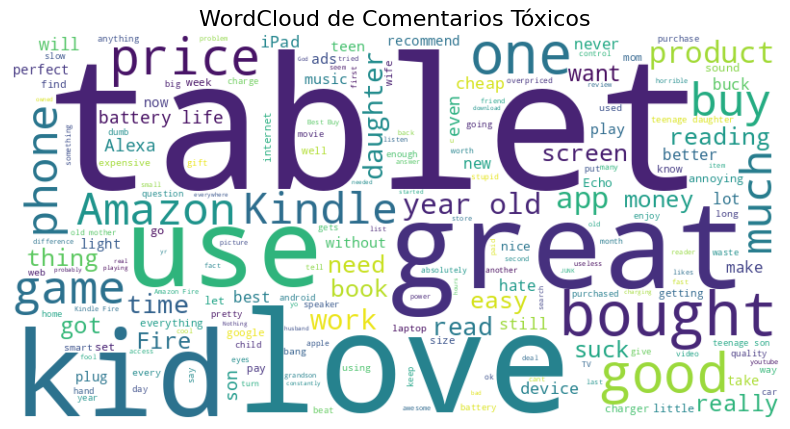

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = result[result['Is Toxic'] == 1]

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Tóxicos", fontsize=16)
plt.show()

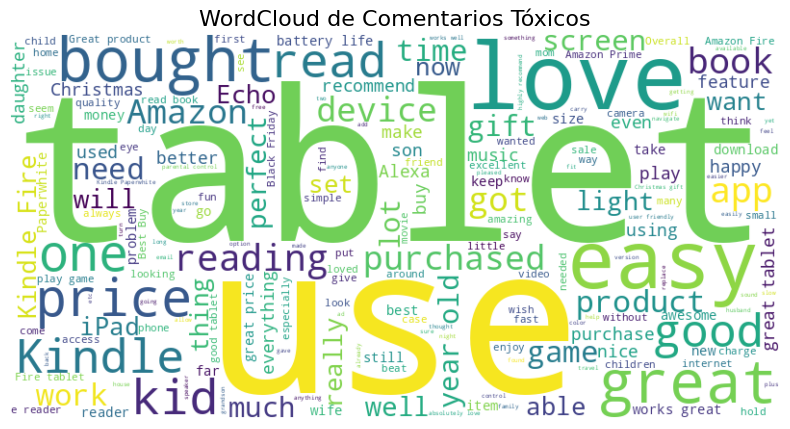

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios No tóxicos
toxic_data = result[result['Is Toxic'] == 0]

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Tóxicos", fontsize=16)
plt.show()

In [ ]:
toxic = result[result['Is Toxic'] == 1].groupby('Rating')
toxic.head(15)

Text  \
42     Does all basic functions of a tablet. Hardcore...   
74     I am very happy with this tablet. The worst th...   
94     Good reader which is why I bought it. Ads are ...   
125    My teenage daughter enjoyed her three year old...   
490    not good, hate it , never buy it again, sucks....   
...                                                  ...   
10342  You get wath you paid not comparable to a appl...   
13697  Love everything about the unit except that it ...   
13833  I hope to have it set up for my disabled daugh...   
19530  Too small for me. Page turning constantly due ...   
23627  continually loses connection to the internet. ...   

       Toxicity Probability  Is Toxic  Rating  
42                 0.515023         1     4.0  
74                 0.682058         1     5.0  
94                 0.608573         1     4.0  
125                0.589103         1     5.0  
490                0.987978         1     1.0  
...                     ...       ...     ...  
10342              0.856492         1     1.0  
13697              0.690319         1     2.0  
13833              0.528501         1     2.0  
19530              0.515812         1     2.0  
23627              0.935748         1     2.0  

[73 rows x 4 columns]

In [ ]:
result = reviewToxicFromData(model_load, reviewsRotten, tokenizer_load, max_len,labelsRotten)

694/694 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step


In [ ]:
result['Is Toxic'].value_counts()

Is Toxic
0    19549
1     2646
Name: count, dtype: int64

In [ ]:
result[result['Is Toxic'] == 1].groupby('Rating').size()

Rating
Fresh     1125
Rotten    1521
dtype: int64

In [ ]:
result[result['Is Toxic'] == 0].groupby('Rating').size()

Rating
Fresh     12434
Rotten     7115
dtype: int64

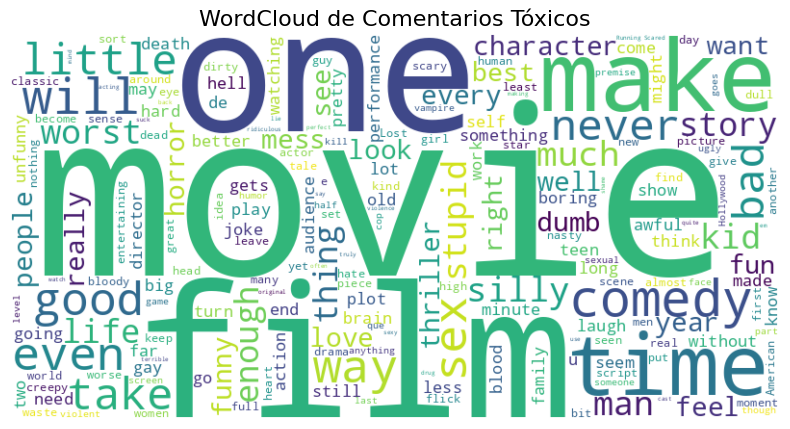

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = result[result['Is Toxic'] == 1]

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Tóxicos", fontsize=16)
plt.show()

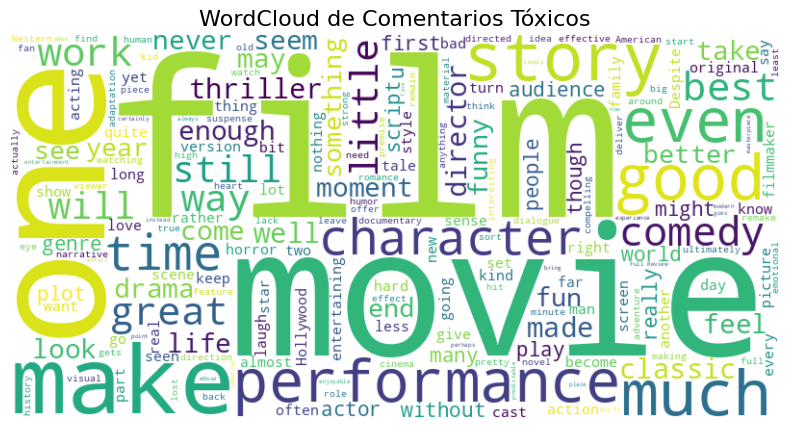

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios No tóxicos
toxic_data = result[result['Is Toxic'] == 0]

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Tóxicos", fontsize=16)
plt.show()

In [ ]:
result.head(15)

Text  Toxicity Probability  \
0   A fantasy adventure that fuses Greek mythology...              0.014166   
1   Uma Thurman as Medusa, the gorgon with a coiff...              0.829276   
2   With a top-notch cast and dazzling special eff...              0.018872   
3   Whether audiences will get behind The Lightnin...              0.040084   
4   What's really lacking in The Lightning Thief i...              0.110815   
5   It's more a list of ingredients than a movie-m...              0.012790   
6   Harry Potter knockoffs don't come more transpa...              0.169234   
7   Percy Jackson isn't a great movie, but it's a ...              0.001489   
8                          Fun, brisk and imaginative              0.108184   
9   Crammed with dragons, set-destroying fights an...              0.385844   
10  This action-packed fantasy adventure, based on...              0.005235   
11  For what it is and for whom it is intended, it...              0.120437   
12  Chris Columbus returns to his comfort zone for...              0.001984   
13  The best thing you can say about Chris Columbu...              0.069297   
14  This cast is simply too generic. None of the y...              0.175230   

    Is Toxic  Rating  
0          0   Fresh  
1          1   Fresh  
2          0   Fresh  
3          0   Fresh  
4          0  Rotten  
5          0  Rotten  
6          0  Rotten  
7          0   Fresh  
8          0   Fresh  
9          0   Fresh  
10         0   Fresh  
11         0  Rotten  
12         0  Rotten  
13         0   Fresh  
14         0  Rotten

# Prueba Review Modelo de Dataset Sentimientos LSTM

In [ ]:
reviews = pd.read_csv('/content/1429_1.csv')

<ipython-input-166-df2f263ea0df>:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('/content/1429_1.csv')


In [ ]:
labelsAmazon = {'Text': 'reviews.text', 'Rating': 'reviews.rating'}
reviews = reviews[[labelsAmazon['Text'] , labelsAmazon['Rating']]]
reviews = reviews.dropna()
reviews.head()

reviews.text  reviews.rating
0  This product so far has not disappointed. My c...             5.0
1  great for beginner or experienced person. Boug...             5.0
2  Inexpensive tablet for him to use and learn on...             5.0
3  I've had my Fire HD 8 two weeks now and I love...             4.0
4  I bought this for my grand daughter when she c...             5.0

In [ ]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

def reviewToxicFromData(model, data, tokenizer, max_len, labels, threshold=0.9):
    """
    Realiza una predicción sobre si un conjunto de datos es tóxico o no.

    Parámetros:
    - model: Modelo entrenado de clasificación de toxicidad.
    - data: Pandas DataFrame que contiene los textos a evaluar.
    - tokenizer: Instancia de `Tokenizer` utilizada para entrenar el modelo.
    - max_len: Longitud máxima de las secuencias de entrada utilizada en el modelo.
    - labels: Diccionario con claves 'Text' y 'Rating', que mapean a las columnas del DataFrame.
    - threshold: Umbral de probabilidad para determinar cuán "segura" es la predicción.

    Retorna:
    - Un DataFrame con el texto original, las predicciones de toxicidad y la probabilidad de la clase predicha.
    """
    # Verificar que las columnas requeridas existan
    if not {labels['Text'], labels['Rating']}.issubset(data.columns):
        raise ValueError("El DataFrame debe contener las columnas especificadas en 'labels'.")

    # Extraer textos y ratings
    text_data = data[labels['Text']].astype(str).tolist()  # Convertir a lista de strings
    ratings = data[labels['Rating']].tolist()

    # Preprocesamiento del texto
    text_sequences = tokenizer.texts_to_sequences(text_data)  # Tokenizar los textos
    text_padded = pad_sequences(text_sequences, maxlen=max_len)  # Aplicar padding

    # Predicción
    predictions = model.predict(text_padded)  # Predecir probabilidades para cada clase

    # Obtener la clase con la mayor probabilidad
    predicted_classes = predictions.argmax(axis=-1)  # Índices de las clases más probables
    predicted_probs = predictions.max(axis=-1)  # Probabilidades de las clases más probables

    # Mapear los índices a etiquetas de clases
    class_labels = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}

    # Inicializamos el vector de predicciones
    predicted_labels = []

    for prob, idx in zip(predicted_probs, predicted_classes):
        if prob >= threshold:  # Si la probabilidad es mayor o igual al umbral, usamos la clase predicha
            predicted_labels.append(class_labels[idx])
        else:  # Si la probabilidad es baja, asignamos "Neutro"
            predicted_labels.append('Neutro')

    # Crear un DataFrame con los resultados
    results = pd.DataFrame({
        'Text': text_data,
        'Predicted Class': predicted_labels,
        'Rating': ratings,
        'Probability': predicted_probs
    })

    return results



In [ ]:
results = reviewToxicFromData(toxic_LSTM, reviews, token, max_len,labelsAmazon)

1083/1083 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


In [ ]:
results.head()

Text Predicted Class  Rating
0  This product so far has not disappointed. My c...          Neutro     5.0
1  great for beginner or experienced person. Boug...        Positivo     5.0
2  Inexpensive tablet for him to use and learn on...        Positivo     5.0
3  I've had my Fire HD 8 two weeks now and I love...        Positivo     4.0
4  I bought this for my grand daughter when she c...        Negativo     5.0

In [ ]:
results['Predicted Class'].value_counts()

Predicted Class
Positivo    20140
Neutro      14045
Negativo      441
Name: count, dtype: int64

In [ ]:
results['Predicted Class'].value_counts()

Predicted Class
Positivo    20140
Neutro      14045
Negativo      441
Name: count, dtype: int64

In [ ]:
reviews['reviews.rating'].value_counts()


reviews.rating
5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: count, dtype: int64

In [ ]:
results[results['Predicted Class'] == 'Positivo'].groupby('Rating').size()

Rating
1.0       26
2.0       42
3.0      352
4.0     4257
5.0    15463
dtype: int64

In [ ]:
results[results['Predicted Class'] == 'Negativo'].groupby('Rating').size()

Rating
1.0     75
2.0     59
3.0     73
4.0    125
5.0    109
dtype: int64

In [ ]:
results[results['Predicted Class'] == 'Neutro'].groupby('Rating').size()

Rating
1.0     309
2.0     301
3.0    1074
4.0    4159
5.0    8202
dtype: int64

In [ ]:
results[results['Predicted Class'] == 'Negativo'].head(20)

Text Predicted Class  \
38    I bought 3 tablets and my family was not disap...        Negativo   
52    I purchased the kindle fire because I needed a...        Negativo   
354   Though I have got it for cheap price during bl...        Negativo   
369   less expensive than last year with so many mor...        Negativo   
405   I have had a Kindle before, and needed a new o...        Negativo   
490   not good, hate it , never buy it again, sucks....        Negativo   
607   This is not a bad product. Amazon offers great...        Negativo   
706   Worse graphics, won't keep a wireless connecti...        Negativo   
819   I love my kindle, it is what I like to use at ...        Negativo   
1020  the first worked fine for three weeks then sto...        Negativo   
1058  Got this to replace the Samsung tab A 7". That...        Negativo   
1085  As I reviewed different tablets, this tablet k...        Negativo   
1178  The only reason why I have not given a 5 star ...        Negativo   
1298  For the price, this tablet is not bad. I found...        Negativo   
1406  I bought this for my son. He been reading book...        Negativo   
1413  It does everything my kids need without having...        Negativo   
1428  Can't beat for price,feels expensive but isn't...        Negativo   
1474  horrible...just like the other 7 i have owned ...        Negativo   
1499  Inexpensive, No need to worry about it getting...        Negativo   
1584  Hoped this Fire HD 8 would be faster than my o...        Negativo   

      Rating  Probability  
38       5.0     0.939648  
52       4.0     0.937653  
354      3.0     0.900042  
369      5.0     0.901089  
405      4.0     0.961190  
490      1.0     0.980570  
607      1.0     0.935968  
706      3.0     0.965898  
819      4.0     0.986391  
1020     3.0     0.971414  
1058     4.0     0.981427  
1085     4.0     0.915878  
1178     4.0     0.972391  
1298     4.0     0.985266  
1406     5.0     0.938083  
1413     5.0     0.935187  
1428     4.0     0.995587  
1474     1.0     0.997088  
1499     5.0     0.982164  
1584     3.0     0.948083

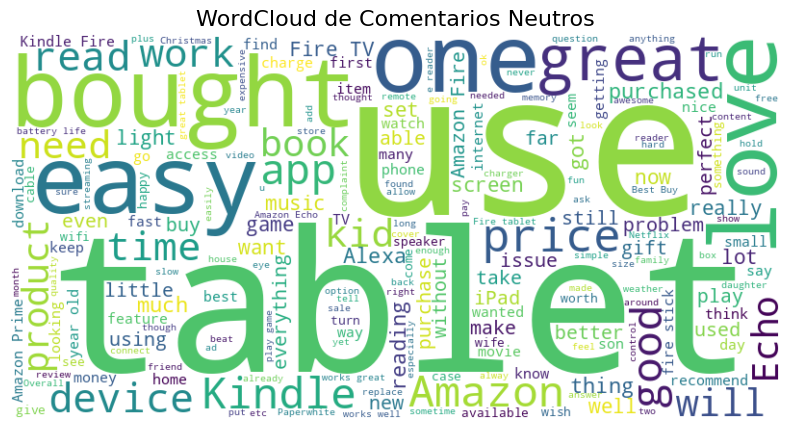

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = results[results['Predicted Class'] == 'Neutro']

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Neutros", fontsize=16)
plt.show()

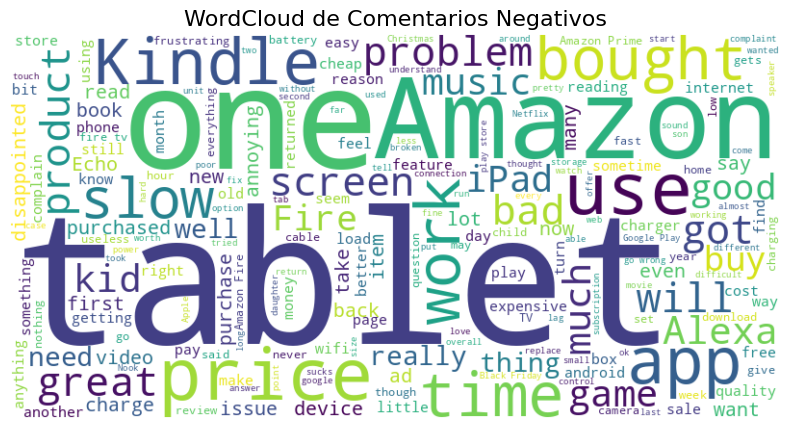

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = results[results['Predicted Class'] == 'Negativo']

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Negativos", fontsize=16)
plt.show()

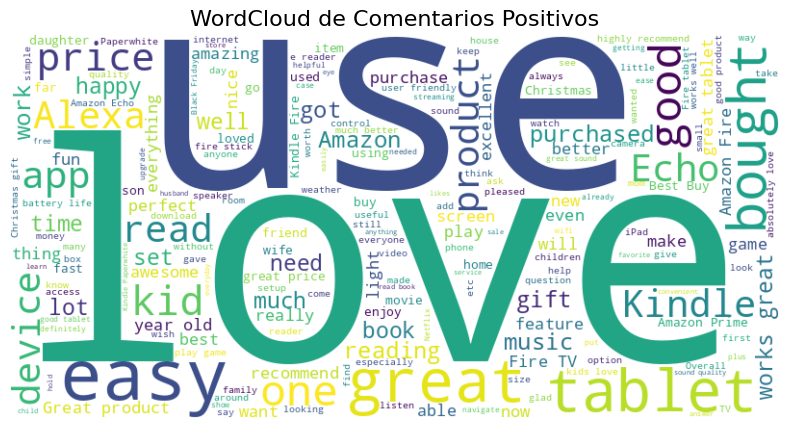

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = results[results['Predicted Class'] == 'Positivo']

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Positivos", fontsize=16)
plt.show()

# Prueba review Modelo de Dataset Sentimientos BERT

In [ ]:
reviews = pd.read_csv('/content/1429_1.csv')

<ipython-input-27-df2f263ea0df>:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('/content/1429_1.csv')


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import pandas as pd
from torch.nn.functional import softmax

def review_toxic_from_data(model, data, tokenizer, max_len, device, labels):
    """
    Realiza una predicción sobre un conjunto de datos.
    """
    # Extraer los textos y ratings
    text_data = data[labels['Text']].astype(str).values
    ratings = data[labels['Rating']].values

    # Tokenizar los textos
    encodings = tokenizer(
        text_data.tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

    # Crear TensorDataset solo con input_ids y attention_mask
    eval_dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    eval_loader = DataLoader(eval_dataset, batch_size=16)

    # Realizar predicciones
    model.eval()
    all_probabilities = []  # Collect probabilities for all batches
    all_predictions = []   # Collect predictions for all batches

    with torch.no_grad():
        for batch in eval_loader:
            input_ids, attention_mask = [b.to(device) for b in batch]

            # Realizar predicción con el modelo
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Salidas del modelo antes de aplicar softmax

            # Aplicar softmax para obtener probabilidades de cada clase
            probabilities = softmax(logits, dim=-1)  # Cada fila suma a 1, columnas corresponden a las clases

            # Determinar la clase predicha como el índice de la probabilidad máxima
            predictions = torch.argmax(probabilities, dim=-1)  # Etiquetas predichas (0: neutra, 1: negativa, 2: positiva)

            all_probabilities.extend(probabilities.cpu().numpy().tolist())
            all_predictions.extend(predictions.cpu().numpy().tolist())

    class_labels = {0: 'Negativo', 1: 'Neutro', 2: 'Positivo'}  # Etiquetas legibles

    # Crear DataFrame con los resultados
    results = pd.DataFrame({
        'Text': text_data,
        'Predicted Class': [class_labels[pred] for pred in all_predictions],  # Etiquetas legibles
        'Rating': ratings
    })

    return results


In [ ]:
reviews= reviews[:7000]
reviews.shape

(7000, 21)

In [ ]:
# Definir mapeo de columnas
labelsAmazon = {'Text': 'reviews.text', 'Rating': 'reviews.rating'}

torch.cuda.empty_cache()

# Ejecutar predicción
max_len = 128
results = review_toxic_from_data(model,reviews, tokenizer, max_len, device, labelsAmazon)

                                                   Text  \
0     This product so far has not disappointed. My c...   
1     great for beginner or experienced person. Boug...   
2     Inexpensive tablet for him to use and learn on...   
3     I've had my Fire HD 8 two weeks now and I love...   
4     I bought this for my grand daughter when she c...   
...                                                 ...   
6995  My 5 y.o. and 2y.o have been using theirs for ...   
6996  God tablet for young kids. Not as fast as an i...   
6997  I bought this on Black Friday for my wife and ...   
6998  My kids had one before I had got free using re...   
6999  I bought the original kindle fire table. To ge...   

                                    Class Probabilities Predicted Class  \
0     [1.9184313714504242e-05, 1.5060581972647924e-0...        Positivo   
1     [3.0949784559197724e-05, 9.121140465140343e-06...        Positivo   
2     [2.8510994525277056e-05, 1.3812691577186342e-0...        Pos

In [ ]:
results.head()

Text  \
0  This product so far has not disappointed. My c...   
1  great for beginner or experienced person. Boug...   
2  Inexpensive tablet for him to use and learn on...   
3  I've had my Fire HD 8 two weeks now and I love...   
4  I bought this for my grand daughter when she c...   

                                 Class Probabilities Predicted Class  Rating  
0  [1.9184313714504242e-05, 1.5060581972647924e-0...        Positivo     5.0  
1  [3.0949784559197724e-05, 9.121140465140343e-06...        Positivo     5.0  
2  [2.8510994525277056e-05, 1.3812691577186342e-0...        Positivo     5.0  
3  [2.4743860194575973e-05, 9.224297173204832e-06...        Positivo     4.0  
4  [2.4457342078676447e-05, 1.106240688386606e-05...        Positivo     5.0

In [ ]:
results['Predicted Class'].value_counts()

Predicted Class
Positivo    5619
Neutro      1110
Negativo     271
Name: count, dtype: int64

In [ ]:
reviews['reviews.rating'].value_counts()


reviews.rating
5.0    4419
4.0    2019
3.0     349
1.0     109
2.0      81
Name: count, dtype: int64

In [ ]:
results[results['Predicted Class'] == 'Positivo'].groupby('Rating').size()

Rating
1.0       7
2.0      12
3.0     146
4.0    1535
5.0    3908
dtype: int64

In [ ]:
results[results['Predicted Class'] == 'Negativo'].groupby('Rating').size()

Rating
1.0    49
2.0    37
3.0    66
4.0    71
5.0    46
dtype: int64

In [ ]:
results[results['Predicted Class'] == 'Neutro'].groupby('Rating').size()

Rating
1.0     53
2.0     32
3.0    137
4.0    413
5.0    465
dtype: int64

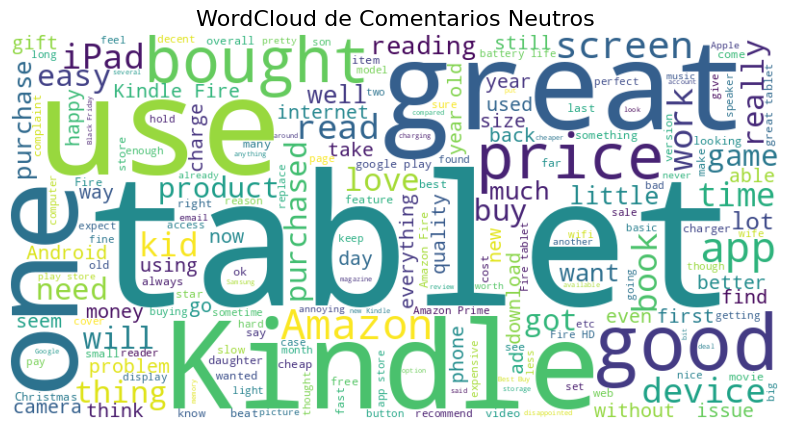

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = results[results['Predicted Class'] == 'Neutro']

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Neutros", fontsize=16)
plt.show()

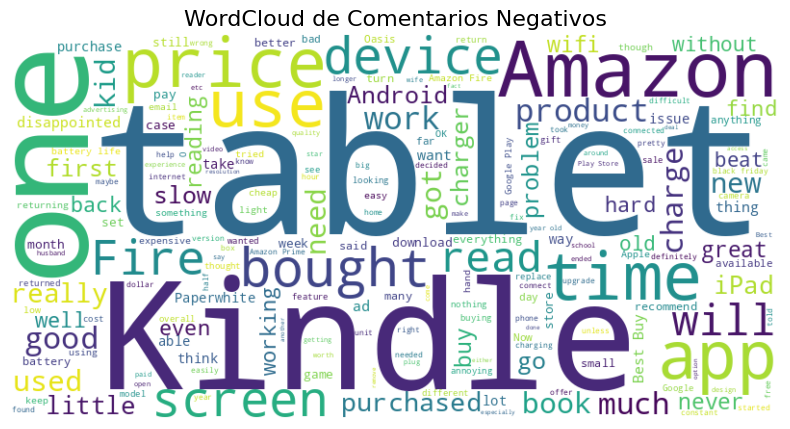

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = results[results['Predicted Class'] == 'Negativo']

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Negativos", fontsize=16)
plt.show()

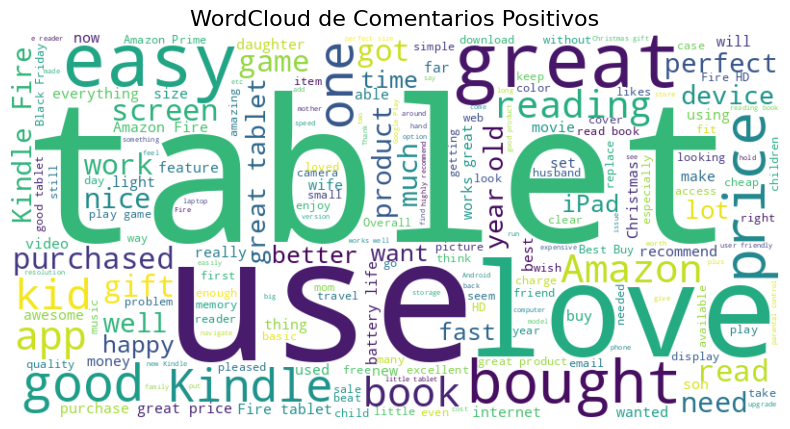

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtra los datos para incluir solo los comentarios tóxicos
toxic_data = results[results['Predicted Class'] == 'Positivo']

# Combina todos los comentarios tóxicos en un único texto
toxic_text = " ".join(toxic_data['Text'].values)

# Genera el WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(toxic_text)

# Visualiza el WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de Comentarios Positivos", fontsize=16)
plt.show()